# 栄養パターンに基づく口腔・上部消化管がん分類モデルの構築および評価４（栄養パターンVer）

In [1]:
%reset -f

# 概要

## パッケージインストール

In [4]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib
from sklearn.linear_model import LinearRegression
!pip install statsmodels
from statsmodels.duration.hazard_regression import PHReg
!pip install factor_analyzer
from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from decimal import Decimal, ROUND_HALF_UP
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.tree import plot_tree
import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score, make_scorer
import joblib
import pandas as pd
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay
import io
from contextlib import redirect_stdout
from IPython.display import display
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelBinarizer 
import shap
import os

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## データの読み込み

In [8]:
# データの読み込み
adjusted_z_df=pd.read_csv("adjusted_z_df.csv")
pcaDF_TN_proj=pd.read_csv('pcaDF_TN_proj.csv')

In [ ]:
display(pcaDF_TN_proj)

## 学習用データとテスト用データの作成

In [ ]:

xDF_all = adjusted_z_df.copy()

#Prepare outputs/classes of all samples

yDF_all = pcaDF_TN_proj["TargetName"]
#Check
print('Inputs:')
display(xDF_all)
display(xDF_all.shape)
print('Outputs:')
display(yDF_all)
display(yDF_all.shape)

In [ ]:
#Split the dataset into training and testing sets
xDF_train, xDF_test, yDF_train, yDF_test = train_test_split(xDF_all, yDF_all,
                                                            test_size=0.2, shuffle=True, random_state=123)

#Check the np.array shape
display(xDF_train.shape)
display(xDF_test.shape)
display(yDF_train.shape)
display(yDF_test.shape)
display(xDF_train)
display(xDF_test)
display(yDF_train)

In [ ]:
# TargetNameのデータ数確認
yDF_test.value_counts(dropna=False)

In [ ]:
# TargetNameのデータ数確認
yDF_train.value_counts(dropna=False)

## ハイパーパラメータの最適化

In [9]:
n_estimators_space = np.unique([int(x) for x in np.logspace(1, 3, num=7, endpoint=True)])
n_estimators_space = n_estimators_space[n_estimators_space > 0]
# Prepare hyperparameter space to be searched 
param_space = {
    'n_estimators': n_estimators_space, 
    'max_depth': [int(i) for i in range(3, 11)],  #1から10まで
    
    'min_samples_leaf': [int(i) for i in np.unique(np.logspace(0, 2, num=10, endpoint=False))], 
    # np.logspace(0, 2, num=10) で 1から100までを対数的に10点でカバー。
    
    'max_features': ['sqrt', 'log2', 4, 5, 10, 15, 21, 26, 30], 
    # 21で頭打ちの可能性を考慮し、21より大きい値を手動で追加 (例: 26, 30)。
}

#Prepare a model while setting hyperparameters
model = RandomForestClassifier(criterion='gini',
                               #max_depth=None,
                               min_samples_split=2,
                               #min_samples_leaf=1,
                               min_weight_fraction_leaf=0.0,
                               #max_features=None,
                               random_state=123,#Specified for reproducibility
                               max_leaf_nodes=None,
                               min_impurity_decrease=0.0,
                               class_weight='balanced',
                               ccp_alpha=0.0)

#Prepare CV generator
cv_gen = StratifiedKFold(n_splits=5, shuffle=True, random_state=123)#Specified for reproducibility

#Wrap the model for tuning hyperparameters with cross-validation
modelcv = GridSearchCV(model, param_grid=param_space,
                       scoring=None, n_jobs=None, refit=True, cv=cv_gen,
                       verbose=0, pre_dispatch='2*n_jobs', error_score=np.nan, return_train_score=False)

#Fit models with all set of parameters on the training set
modelcv.fit(xDF_train, yDF_train.values.ravel())

#Check the CV results
print('Best score:', modelcv.best_score_)
print('Best hyperparameters:', modelcv.best_params_)
tempDF = pd.DataFrame(modelcv.cv_results_).sort_values('mean_test_score', ascending=False)
display(tempDF)

Best score: 0.5331755256627922
Best hyperparameters: {'max_depth': 6, 'max_features': 10, 'min_samples_leaf': 39, 'n_estimators': 10}


mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
2226       0.031713      0.001235         0.001266        0.000016   
1673       0.032856      0.000570         0.001258        0.000010   
4565       0.059682      0.003449         0.001839        0.000255   
4425       0.059656      0.001224         0.001856        0.000123   
4495       0.058259      0.001131         0.001712        0.000014   
...             ...           ...              ...             ...   
121        0.061685      0.001145         0.002135        0.000109   
191        0.060468      0.000599         0.002087        0.000048   
51         0.062055      0.001859         0.002156        0.000129   
4643       0.153171      0.016322         0.002839        0.000481   
4004       0.032829      0.002323         0.001319        0.000024   

      param_max_depth param_max_features  param_min_samples_leaf  \
2226                6                 10                      39   
1673                5                 15                      63   
4565               10                  4                       2   
4425               10               sqrt                       2   
4495               10               log2                       2   
...               ...                ...                     ...   
121                 3               log2                      25   
191                 3                  4                      25   
51                  3               sqrt                      25   
4643               10                  5                       3   
4004                9                  5                       2   

      param_n_estimators                                             params  \
2226                  10  {'max_depth': 6, 'max_features': 10, 'min_samp...   
1673                  10  {'max_depth': 5, 'max_features': 15, 'min_samp...   
4565                  21  {'max_depth': 10, 'max_features': 4, 'min_samp...   
4425                  21  {'max_depth': 10, 'max_features': 'sqrt', 'min...   
4495                  21  {'max_depth': 10, 'max_features': 'log2', 'min...   
...                  ...                                                ...   
121                   46  {'max_depth': 3, 'max_features': 'log2', 'min_...   
191                   46  {'max_depth': 3, 'max_features': 4, 'min_sampl...   
51                    46  {'max_depth': 3, 'max_features': 'sqrt', 'min_...   
4643                  46  {'max_depth': 10, 'max_features': 5, 'min_samp...   
4004                  10  {'max_depth': 9, 'max_features': 5, 'min_sampl...   

      split0_test_score  split1_test_score  split2_test_score  \
2226           0.528226           0.558704           0.542510   
1673           0.504032           0.526316           0.582996   
4565           0.528226           0.542510           0.530364   
4425           0.528226           0.542510           0.530364   
4495           0.528226           0.542510           0.530364   
...                 ...                ...                ...   
121            0.483871           0.465587           0.497976   
191            0.483871           0.465587           0.497976   
51             0.483871           0.465587           0.497976   
4643           0.447581           0.465587           0.506073   
4004           0.459677           0.457490           0.469636   

      split3_test_score  split4_test_score  mean_test_score  std_test_score  \
2226           0.526316           0.510121         0.533176        0.016382   
1673           0.506073           0.538462         0.531576        0.028734   
4565           0.550607           0.502024         0.530746        0.016518   
4425           0.550607           0.502024         0.530746        0.016518   
4495           0.550607           0.502024         0.530746        0.016518   
...                 ...                ...              ...             ...   
121            0.481781           0.417004         0.469244      

In [10]:
# 最適なモデルを取得
best_model = modelcv.best_estimator_

# モデルをファイルに保存
filename = 'best_random_forest_None_model.joblib'
joblib.dump(best_model, filename)

print(f"最適なモデルを {filename} に保存しました。")

最適なモデルを best_random_forest_None_model.joblib に保存しました。


In [5]:
filename = 'best_random_forest_None_model.joblib'
model = joblib.load(filename)

## 分類モデルの精度分析

### 分類モデルの精度結果

In [12]:
#Evaluate the model on the testing set, based on classification accuracy
score = model.score(xDF_test, yDF_test)
print('Classification accuracy:', score)

#Predict classes of the testing set
tempA = model.predict(xDF_test)
##Clean
tempS = pd.Series(tempA, index=xDF_test.index, name='PredictedClass')
tempDF = yDF_test.rename('TrueClass') 
tempDF = pd.merge(tempS, tempDF, left_index=True, right_index=True, how='left')

#Check
#display(tempDF)
#display(tempDF.describe(include='all'))
display(tempDF['TrueClass'].value_counts())
display(tempDF['PredictedClass'].value_counts())
display(tempDF.loc[tempDF['TrueClass']!=tempDF['PredictedClass']])

Classification accuracy: 0.5580645161290323


TrueClass
oral_cancer    155
non_cancer     155
Name: count, dtype: int64

PredictedClass
non_cancer     164
oral_cancer    146
Name: count, dtype: int64

PredictedClass    TrueClass
680      non_cancer  oral_cancer
448     oral_cancer   non_cancer
309      non_cancer  oral_cancer
605     oral_cancer   non_cancer
466     oral_cancer   non_cancer
...             ...          ...
1498     non_cancer  oral_cancer
512      non_cancer  oral_cancer
550     oral_cancer   non_cancer
1355    oral_cancer   non_cancer
945     oral_cancer   non_cancer

[137 rows x 2 columns]

### 決定木モデルの一例

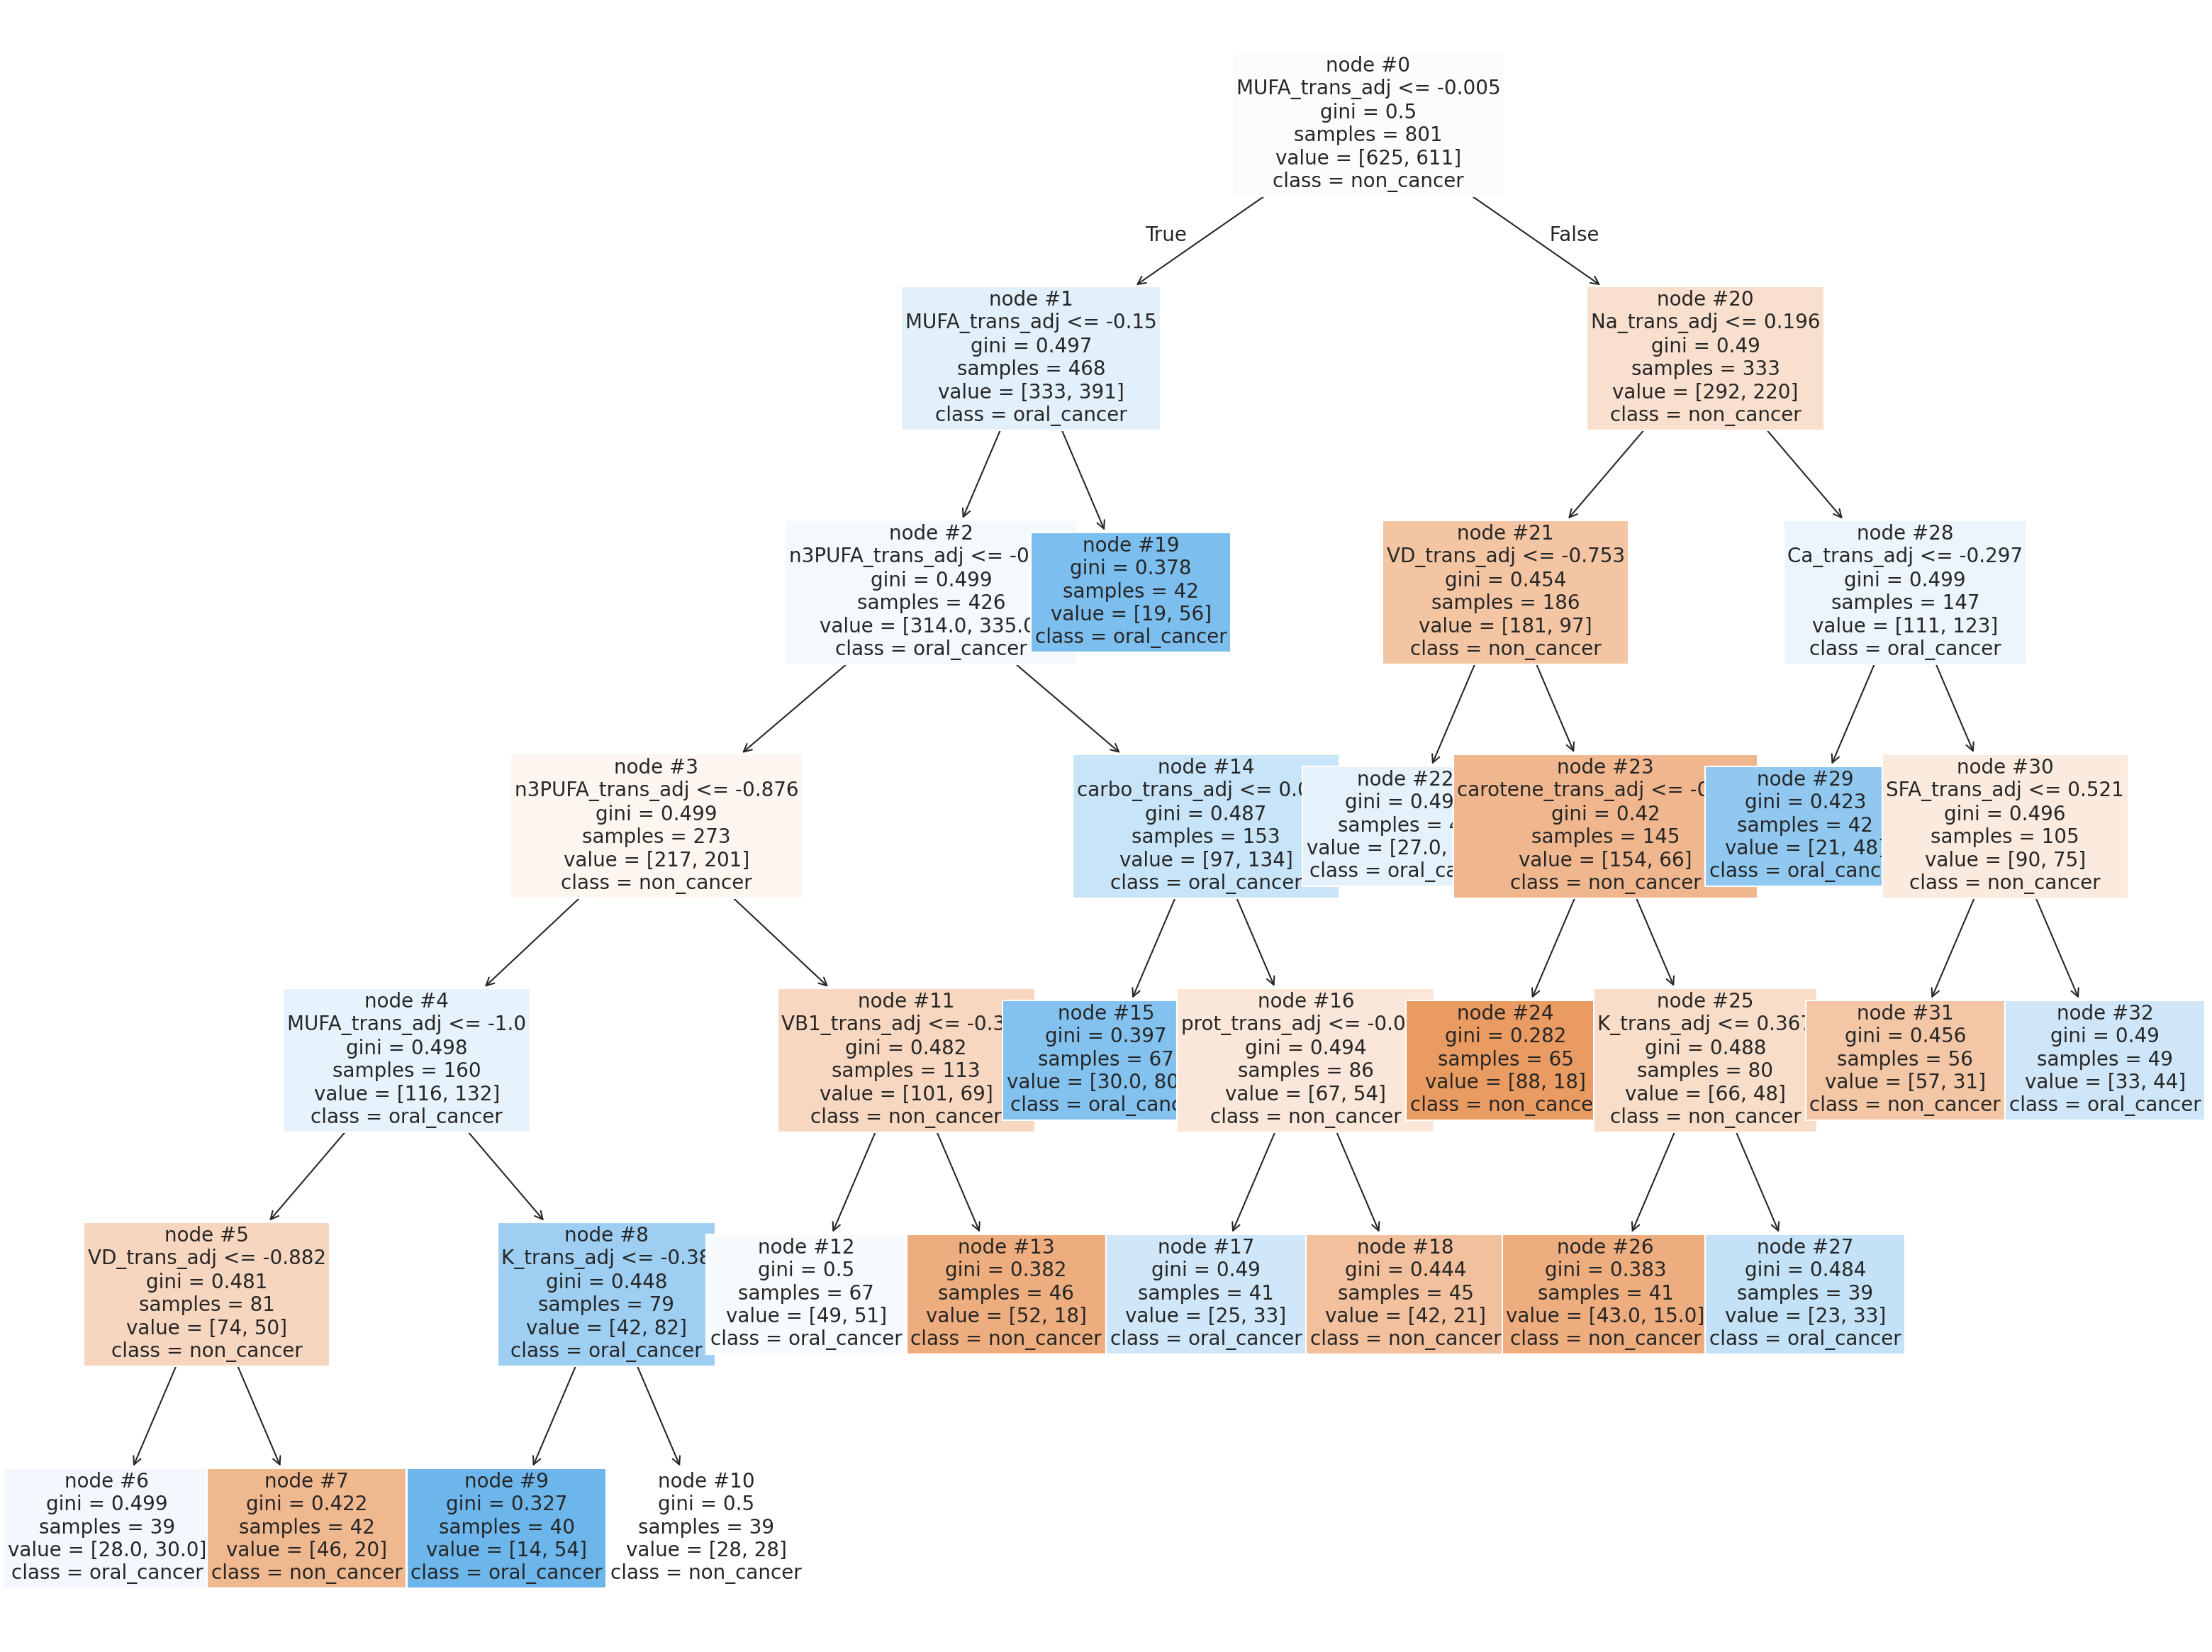

In [13]:
# 1. 学習済みのRandomForestClassifierから、構成要素である単一の決定木を取り出す
#    ここでは、model.estimators_[0]（0番目の木）を使用
sns.set(style='ticks', context='talk')
single_tree = model.estimators_[0]

# 2. 可視化の実行
plt.figure(figsize=(40, 30))
plot_tree(
    decision_tree=single_tree,                     
    feature_names=xDF_train.columns.tolist(),      
    class_names=model.classes_.astype(str).tolist(),
    filled=True, 
    node_ids=True,
    fontsize=20
)

plt.show()

### 特徴量の重要度

In [14]:
importance_scores = model.feature_importances_
feature_names = xDF_train.columns.tolist()
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance_scores
})
sorted_importance_df = importance_df.sort_values(by='Importance', ascending=False)
print(sorted_importance_df)

               Feature  Importance
15      MUFA_trans_adj    0.129445
1      carbo_trans_adj    0.114737
18       IDF_trans_adj    0.071181
6   carotene_trans_adj    0.063282
4         Ca_trans_adj    0.062481
14       SFA_trans_adj    0.057955
16      chol_trans_adj    0.050289
19    n3PUFA_trans_adj    0.048616
5         Fe_trans_adj    0.047456
11       VB2_trans_adj    0.042359
3          K_trans_adj    0.039535
2         Na_trans_adj    0.037073
0       prot_trans_adj    0.036278
7     retiEQ_trans_adj    0.032400
9         VE_trans_adj    0.030926
17       SDF_trans_adj    0.030090
10       VB1_trans_adj    0.028067
13        VC_trans_adj    0.023482
12    folate_trans_adj    0.021309
20    n6PUFA_trans_adj    0.016896
8         VD_trans_adj    0.016142


### 混同行列

In [15]:
y_pred = model.predict(xDF_test)
print(classification_report(yDF_test.values.ravel(), y_pred))

              precision    recall  f1-score   support

  non_cancer       0.55      0.59      0.57       155
 oral_cancer       0.56      0.53      0.54       155

    accuracy                           0.56       310
   macro avg       0.56      0.56      0.56       310
weighted avg       0.56      0.56      0.56       310




✅ 全てのテキスト出力は "NUT_model_evaluation_report.txt" に保存されました。
✅ Classification Report のDataFrameは "NUT_classification_report_df.csv" にCSVとして保存されました。
✅ 混同行列のグラフは "NUT_confusion_matrix.png" にPNG画像として保存されました。


--- 実行結果の確認 (画面表示) ---
Accuracy: 0.5580645161290323
-> Cf. Manual calculation: 0.5580645161290323


Classification Report (DataFrame T):


precision    recall  f1-score     support
non_cancer     0.554878  0.587097  0.570533  155.000000
oral_cancer    0.561644  0.529032  0.544850  155.000000
accuracy       0.558065  0.558065  0.558065    0.558065
macro avg      0.558261  0.558065  0.557692  310.000000
weighted avg   0.558261  0.558065  0.557692  310.000000

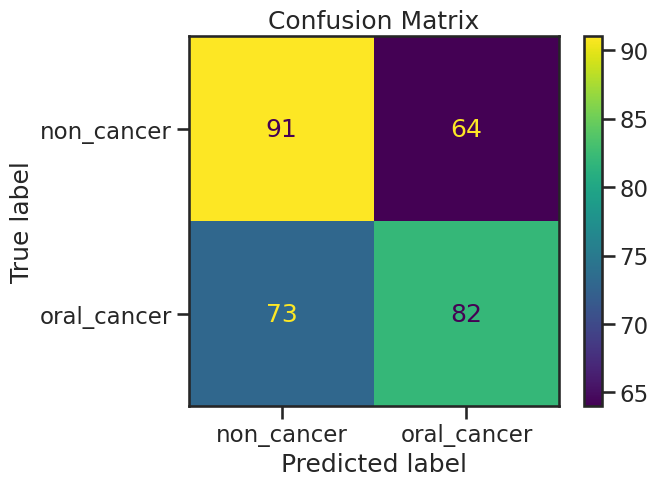

In [16]:
y_pred = model.predict(xDF_test)
tempDF_true = yDF_test.rename('TrueClass') 

# PredictedClass (予測) の準備: Seriesを作成
tempS_pred = pd.Series(y_pred, index=xDF_test.index, name='PredictedClass')

# 結合して最終的な評価用DataFrame (tempDF) を作成
tempDF = pd.merge(tempS_pred, tempDF_true, left_index=True, right_index=True, how='left')
TEXT_OUTPUT_FILENAME = 'NUT_model_evaluation_report.txt'
CLASSIFICATION_REPORT_DF_FILENAME = 'NUT_classification_report_df.csv' # または .xlsx

# バッファを用意し、print出力をリダイレクト
f = io.StringIO()
with redirect_stdout(f):
    print('--- モデル評価結果 ---')
    print()
    # Accuracy
    accuracy = accuracy_score(tempDF['TrueClass'], tempDF['PredictedClass'], normalize=True)
    print('Accuracy:', accuracy)
    # Cf. Manual calculation (手動計算)
    manual_accuracy = (tempDF['TrueClass']==tempDF['PredictedClass']).sum()/len(tempDF)
    print('-> Cf. Manual calculation:', manual_accuracy)

    print('\n' + '='*30 + '\n')

    ## 混同行列の表示 (ここでは表示はスキップし、画像で保存する)
    print('## 混同行列の表示')
    print('Confusion Matrix (グラフ) は ' + 'NUT_confusion_matrix.png' + ' に保存されます。')

    print('\n' + '='*30 + '\n')

    ## Precision, Recall, F1-score の DataFrame 出力
    # output_dict=True で結果を辞書として取得
    tempD = classification_report(tempDF['TrueClass'], tempDF['PredictedClass'], output_dict=True)

    # 辞書をDataFrameに変換
    report_df = pd.DataFrame(tempD).T

    # 最終レポートDataFrameをCSVとして保存
    report_df.to_csv(CLASSIFICATION_REPORT_DF_FILENAME, float_format='%.4f')
    print(f'Classification Report (DataFrame T) は {CLASSIFICATION_REPORT_DF_FILENAME} にCSVとして保存されました。')
    print('\nClassification Report (DataFrame T) の内容:')
    # print関数でDataFrameの内容をファイルに書き込み
    print(report_df.to_string()) # to_string()で整形されたテキスト形式に変換して出力

# リダイレクトされた出力をファイルに書き込み
with open(TEXT_OUTPUT_FILENAME, 'w', encoding='utf-8') as text_file:
    text_file.write(f.getvalue())

print(f'\n✅ 全てのテキスト出力は "{TEXT_OUTPUT_FILENAME}" に保存されました。')
print(f'✅ Classification Report のDataFrameは "{CLASSIFICATION_REPORT_DF_FILENAME}" にCSVとして保存されました。')
CONFUSION_MATRIX_FILENAME = 'NUT_confusion_matrix.png'

# Visualize confusion matrix
ConfusionMatrixDisplay.from_predictions(tempDF['TrueClass'], tempDF['PredictedClass'])
plt.title('Confusion Matrix') # タイトルを追加
# plt.show() の代わりに plt.savefig() でファイルに保存
plt.savefig(CONFUSION_MATRIX_FILENAME, bbox_inches='tight')
plt.close() # グラフ表示を抑止するために閉じる（環境によっては必須）

print(f'✅ 混同行列のグラフは "{CONFUSION_MATRIX_FILENAME}" にPNG画像として保存されました。')

print('\n\n--- 実行結果の確認 (画面表示) ---')
print('Accuracy:', accuracy)
print('-> Cf. Manual calculation:', manual_accuracy)
print('\n' + '='*30 + '\n')
print('Classification Report (DataFrame T):')
display(report_df)
ConfusionMatrixDisplay.from_predictions(tempDF['TrueClass'], tempDF['PredictedClass'])
plt.title('Confusion Matrix')
plt.show()

### ROC曲線

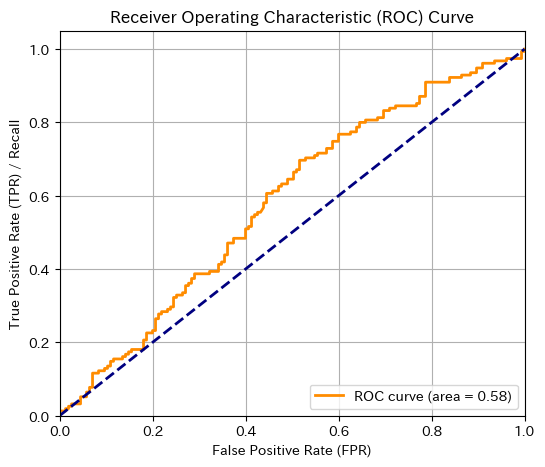


AUC (Area Under the Curve): 0.5816




In [14]:
y_score = model.predict_proba(xDF_test)
ptnA={'non_cancer':0,'oral_cancer':1}
yDF_test_1=yDF_test.map(ptnA)
y_true_binary = yDF_test_1.values.ravel() 

fpr, tpr, thresholds = roc_curve(y_true_binary, y_score[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))

# ROC曲線のプロット
plt.plot(
    fpr, tpr, color='darkorange', lw=2, 
    label=f'ROC curve (area = {roc_auc:0.2f})'
)

# ランダムな分類器の対角線 (AUC=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# グラフの設定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)') # 偽陽性率
plt.ylabel('True Positive Rate (TPR) / Recall') # 真陽性率 / 再現率
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f'\nAUC (Area Under the Curve): {roc_auc:.4f}')
print('\n' + '='*30 + '\n')

### SHAP値の出力

--- SHAP Based Feature Importance (Mean Absolute SHAP Value) ---
               Feature  SHAP_Importance
1      carbo_trans_adj         0.026586
15      MUFA_trans_adj         0.023476
4         Ca_trans_adj         0.014337
5         Fe_trans_adj         0.011378
0       prot_trans_adj         0.010388
18       IDF_trans_adj         0.010269
16      chol_trans_adj         0.008855
19    n3PUFA_trans_adj         0.008709
7     retiEQ_trans_adj         0.008484
2         Na_trans_adj         0.008218
14       SFA_trans_adj         0.007919
3          K_trans_adj         0.007470
6   carotene_trans_adj         0.006998
11       VB2_trans_adj         0.006738
13        VC_trans_adj         0.006393
17       SDF_trans_adj         0.005628
9         VE_trans_adj         0.005529
10       VB1_trans_adj         0.005301
8         VD_trans_adj         0.004662
12    folate_trans_adj         0.003875
20    n6PUFA_trans_adj         0.003134

--- SHAP Summary Plot ---


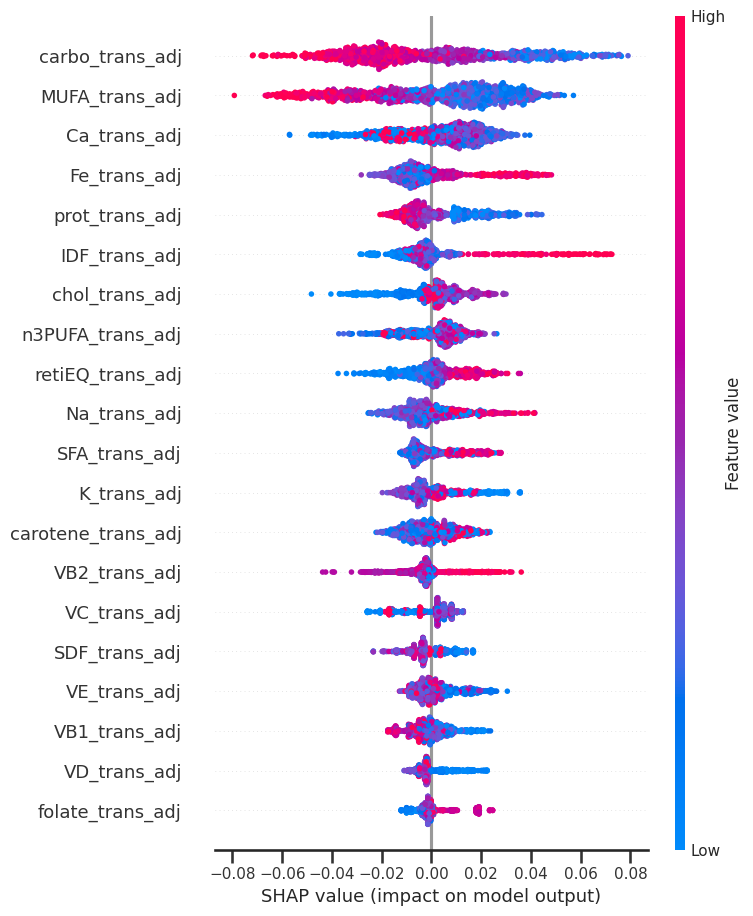

In [18]:
shap.initjs()

# 1. SHAP Explainer の作成 (modelとxDF_trainは定義済みと仮定)
explainer = shap.TreeExplainer(model)

# 2. SHAP値の計算 (実行済み)
shap_values = explainer.shap_values(xDF_train) 

# 適切なSHAP値の抽出 (クラス1のSHAP値)
shap_values_class1 = shap_values[:, :, 1]


# 3. 特徴量のグローバルな重要度 (Mean Absolute SHAP Value) の計算 
shap_v = np.abs(shap_values_class1).mean(axis=0)


# 4. DataFrameの作成 (特徴量名と重要度を結合)
feature_names = xDF_train.columns.tolist()

shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': shap_v
})


# 5. 重要度が高い順にソートして表示 
sorted_shap_importance_df = shap_importance_df.sort_values(by='SHAP_Importance', ascending=False)
print("--- SHAP Based Feature Importance (Mean Absolute SHAP Value) ---")
print(sorted_shap_importance_df)


# 6. SHAP Summary Plotの表示 
print("\n--- SHAP Summary Plot ---")
# Summary Plotに (サンプル数, 特徴量数) の配列を渡す
shap.summary_plot(shap_values_class1, xDF_train)

In [19]:
# Plot保存のために追加
shap.initjs()
# 1. SHAP Explainer の作成 
explainer = shap.TreeExplainer(model)
# 2. SHAP値の計算 (実行済み)
shap_values = explainer.shap_values(xDF_train) 
# 適切なSHAP値の抽出 (クラス1のSHAP値)
shap_values_class1 = shap_values[:, :, 1]


# 3. 特徴量のグローバルな重要度 (Mean Absolute SHAP Value) の計算
shap_v = np.abs(shap_values_class1).mean(axis=0)


# 4. DataFrameの作成 
feature_names = xDF_train.columns.tolist()
shap_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP_Importance': shap_v
})

# 5. 重要度が高い順にソートして表示
sorted_shap_importance_df = shap_importance_df.sort_values(by='SHAP_Importance', ascending=False)
print("--- SHAP Based Feature Importance (Mean Absolute SHAP Value) ---")
print(sorted_shap_importance_df)

csv_filename = 'NUT_shap_feature_importance.csv'
sorted_shap_importance_df.to_csv(csv_filename, index=False)
print(f"\n✅ 特徴量の重要度データを '{csv_filename}' に保存しました。")

# 6. SHAP Summary Plotの表示と保存
print("\n--- SHAP Summary Plotの保存 ---")
# show=False を設定して、プロットの表示を抑制し、plt.savefig() で保存できるようにする
shap.summary_plot(shap_values_class1, xDF_train, show=False)

# プロットをファイルとして保存
plot_filename = 'NUT_shap_summary_plot_class1.png'
plt.savefig(plot_filename, bbox_inches='tight') 
plt.close() # Figureを閉じる

print(f"\n✅ SHAP Summary Plotを '{plot_filename}' に保存しました。")

--- SHAP Based Feature Importance (Mean Absolute SHAP Value) ---
               Feature  SHAP_Importance
1      carbo_trans_adj         0.026586
15      MUFA_trans_adj         0.023476
4         Ca_trans_adj         0.014337
5         Fe_trans_adj         0.011378
0       prot_trans_adj         0.010388
18       IDF_trans_adj         0.010269
16      chol_trans_adj         0.008855
19    n3PUFA_trans_adj         0.008709
7     retiEQ_trans_adj         0.008484
2         Na_trans_adj         0.008218
14       SFA_trans_adj         0.007919
3          K_trans_adj         0.007470
6   carotene_trans_adj         0.006998
11       VB2_trans_adj         0.006738
13        VC_trans_adj         0.006393
17       SDF_trans_adj         0.005628
9         VE_trans_adj         0.005529
10       VB1_trans_adj         0.005301
8         VD_trans_adj         0.004662
12    folate_trans_adj         0.003875
20    n6PUFA_trans_adj         0.003134

✅ 特徴量の重要度データを 'NUT_shap_feature_importance.csv' に保存しまし

In [20]:
try:
    base_value_class1 = explainer.expected_value[1]
except Exception as e:
    # 予期せぬエラーが発生した場合の代替処理 (デバッグ用)
    print(f"Error accessing explainer.expected_value[1]: {e}")
    print("explainer.expected_valueの内容を確認してください。")
    # 代替値（実行を継続するための一時的な措置）
    # 通常はこの処理は不要ですが、エラーを防ぐために配置
    base_value_class1 = 0.0 # 実際の値に合わせて修正が必要です

print(f"Base Value for Class 1 (Expected Output): {base_value_class1:.4f}")

# 3. Force Plotの表示 (NameErrorが発生した部分)
print("\n--- SHAP Force Plot for Multiple Samples (Class 1) ---")
shap.force_plot(
    base_value_class1,       # ここで定義した変数を使用
    shap_values_class1[:100, :],
    xDF_train.iloc[:100, :],
    matplotlib=False
)

Base Value for Class 1 (Expected Output): 0.4917

--- SHAP Force Plot for Multiple Samples (Class 1) ---


--- SHAP Dependence Plots for ALL Features (Class 1) ---

[Plotting Dependence Plot for: prot_trans_adj]


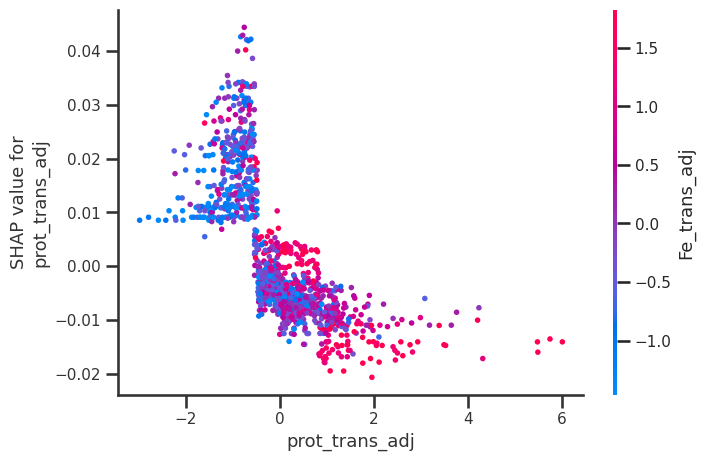


[Plotting Dependence Plot for: carbo_trans_adj]


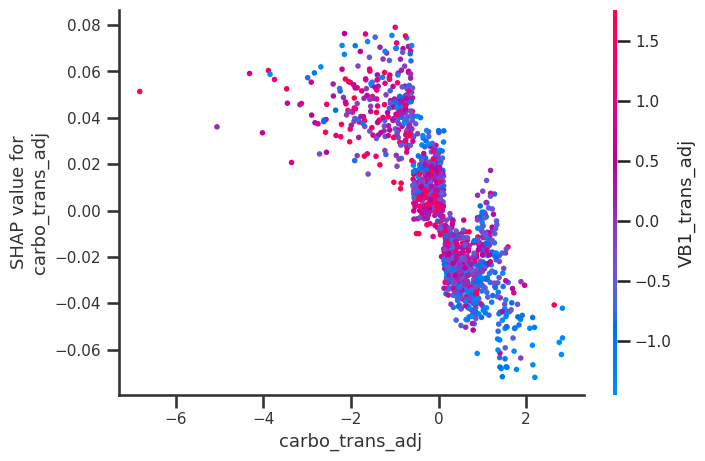


[Plotting Dependence Plot for: Na_trans_adj]


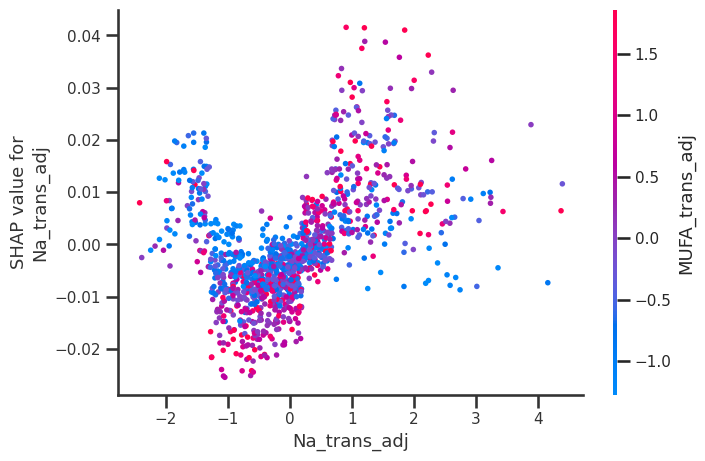


[Plotting Dependence Plot for: K_trans_adj]


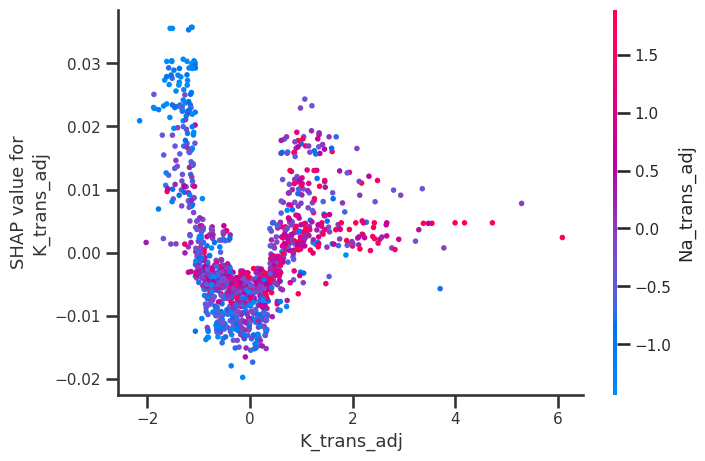


[Plotting Dependence Plot for: Ca_trans_adj]


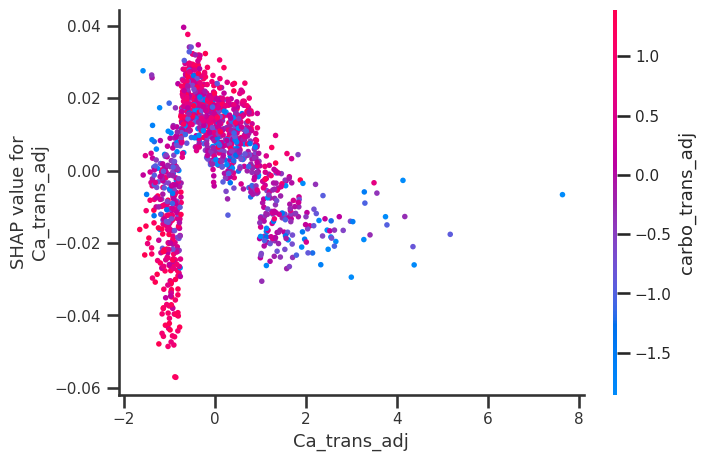


[Plotting Dependence Plot for: Fe_trans_adj]


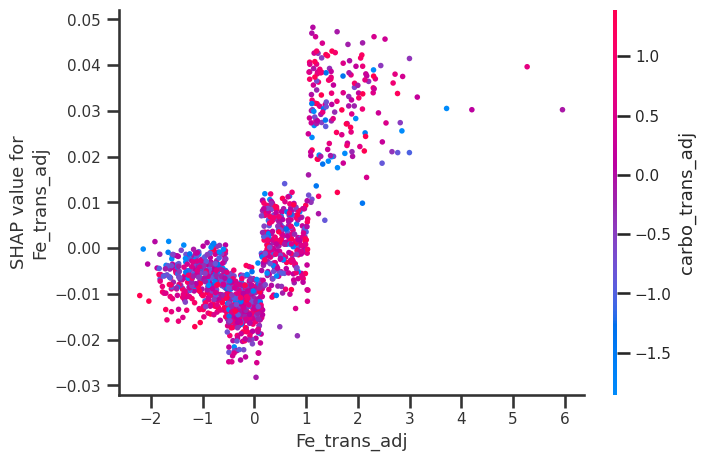


[Plotting Dependence Plot for: carotene_trans_adj]


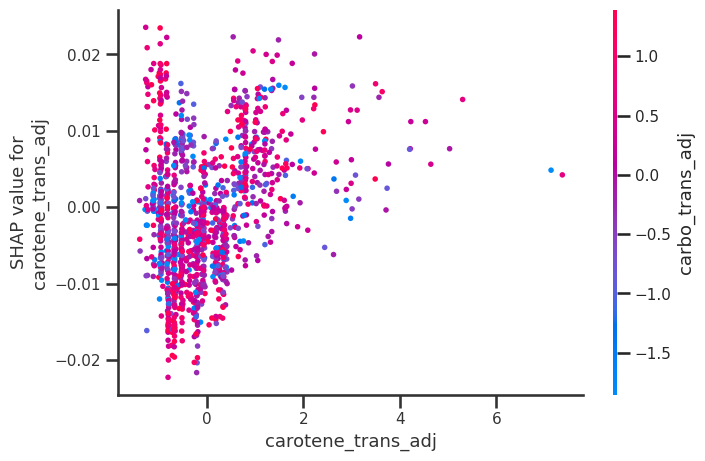


[Plotting Dependence Plot for: retiEQ_trans_adj]


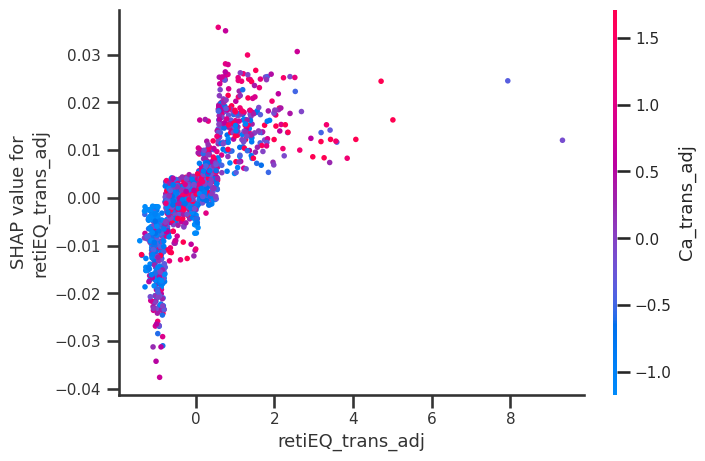


[Plotting Dependence Plot for: VD_trans_adj]


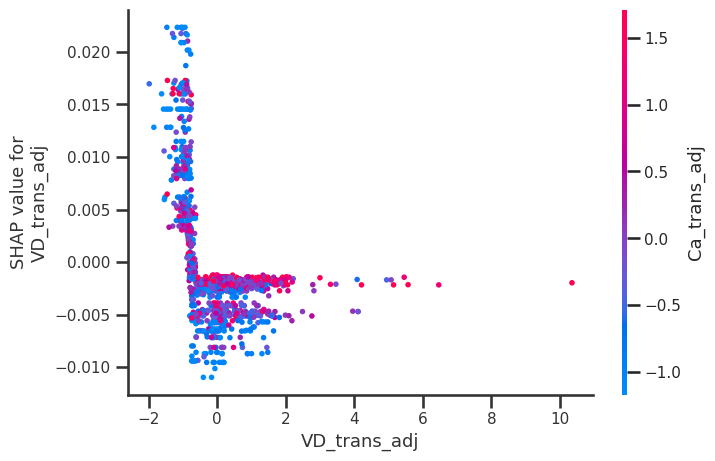


[Plotting Dependence Plot for: VE_trans_adj]


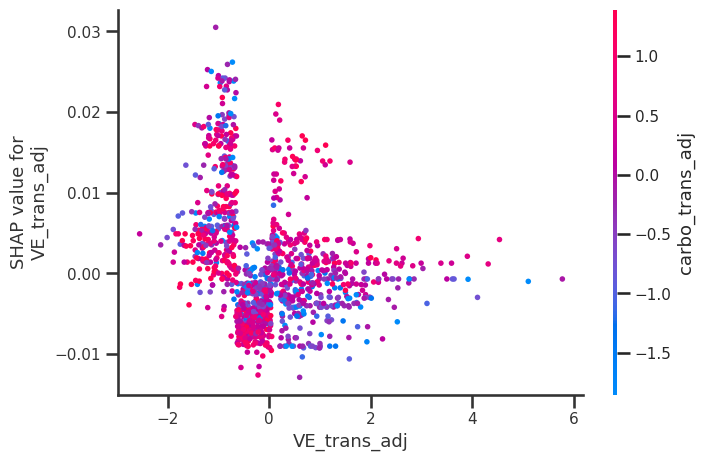


[Plotting Dependence Plot for: VB1_trans_adj]


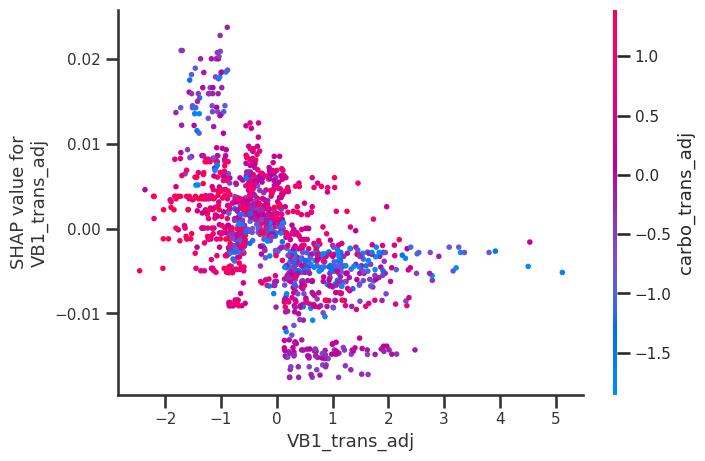


[Plotting Dependence Plot for: VB2_trans_adj]


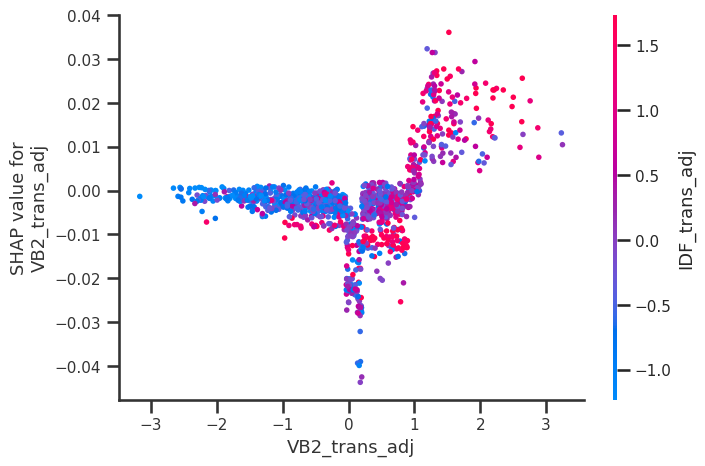


[Plotting Dependence Plot for: folate_trans_adj]


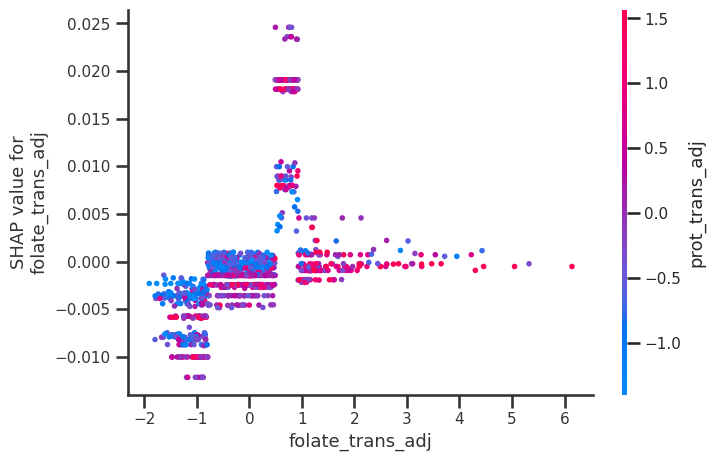


[Plotting Dependence Plot for: VC_trans_adj]


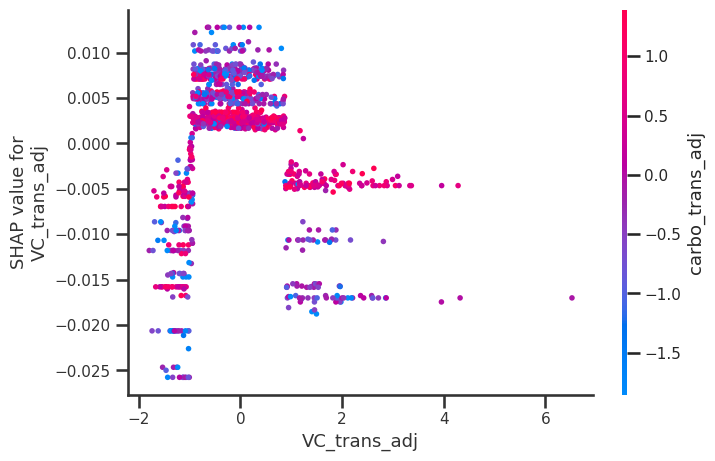


[Plotting Dependence Plot for: SFA_trans_adj]


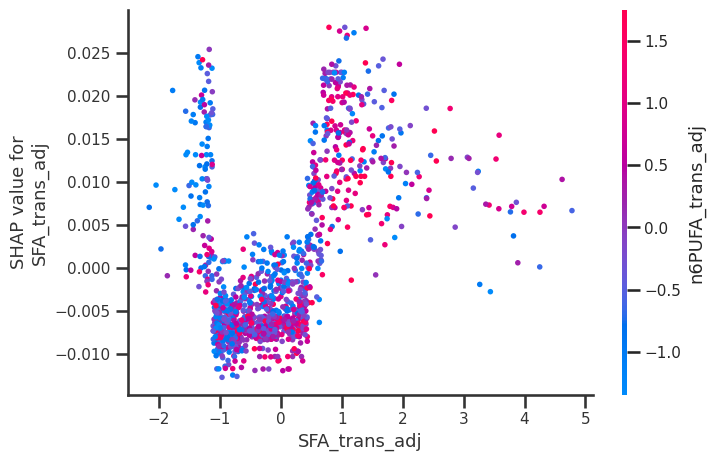


[Plotting Dependence Plot for: MUFA_trans_adj]


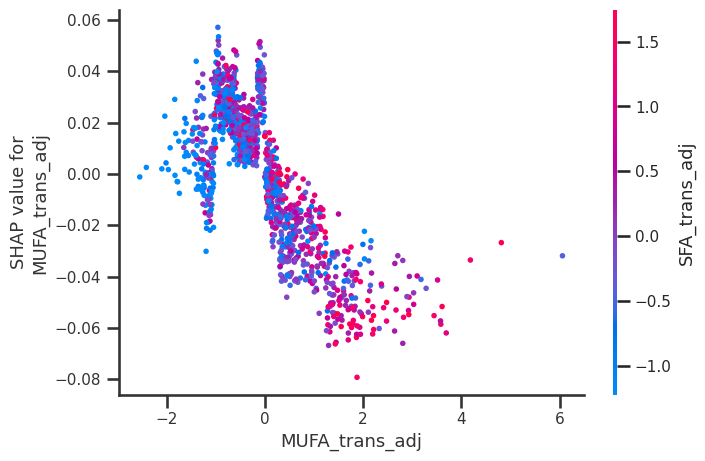


[Plotting Dependence Plot for: chol_trans_adj]


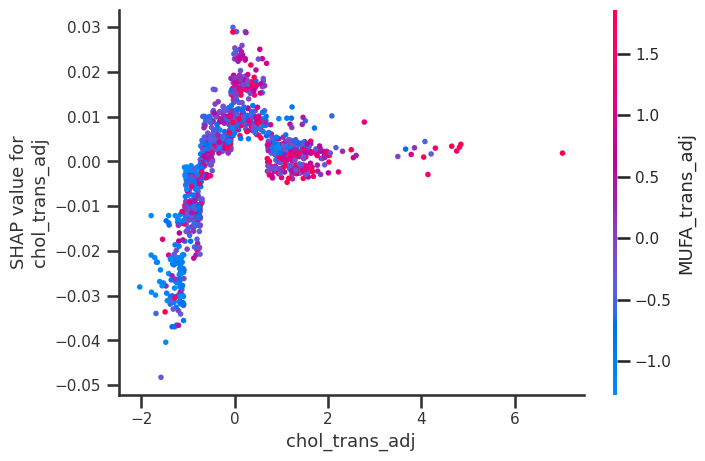


[Plotting Dependence Plot for: SDF_trans_adj]


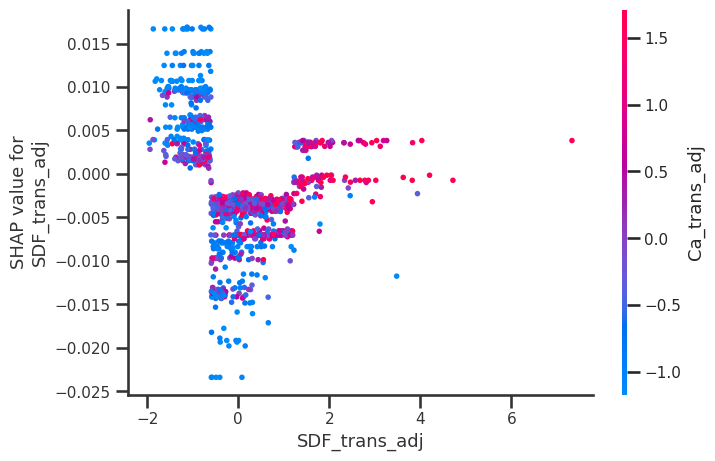


[Plotting Dependence Plot for: IDF_trans_adj]


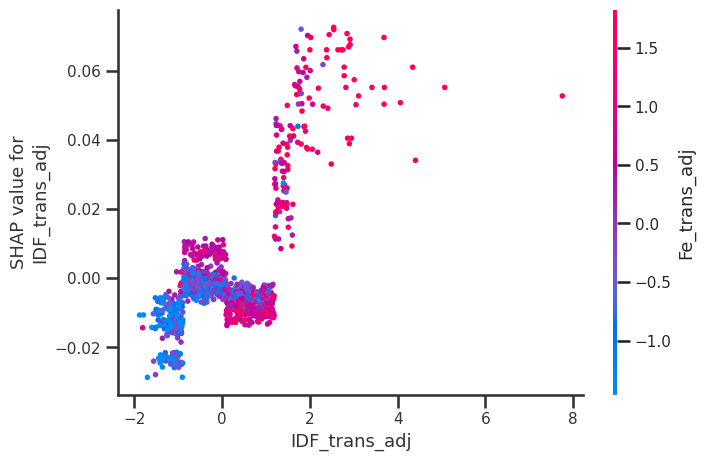


[Plotting Dependence Plot for: n3PUFA_trans_adj]


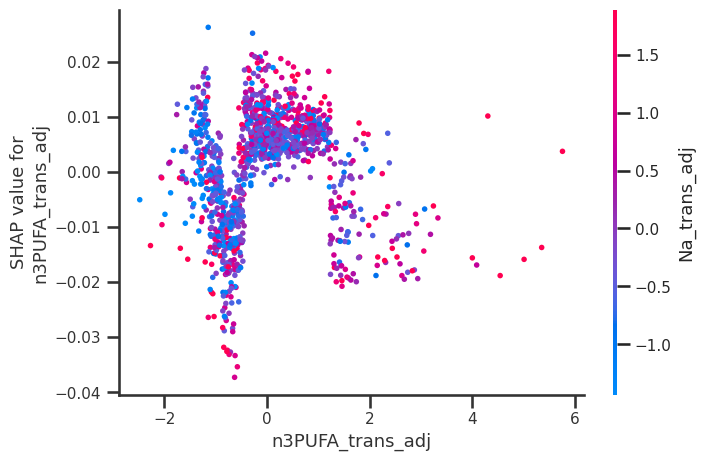


[Plotting Dependence Plot for: n6PUFA_trans_adj]


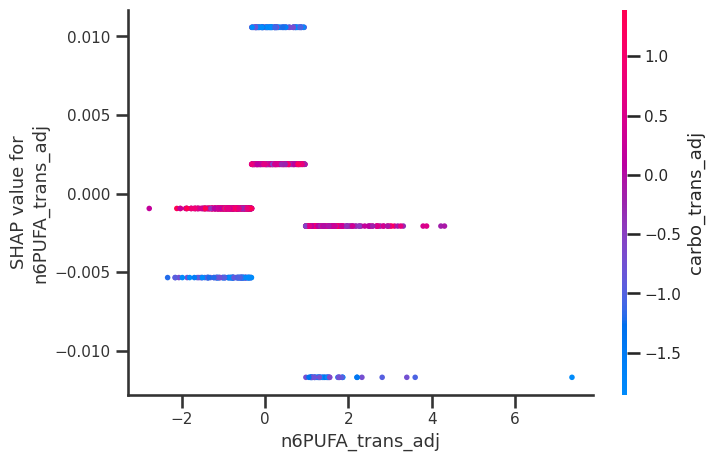

In [21]:
feature_names = xDF_train.columns.tolist()

print("--- SHAP Dependence Plots for ALL Features (Class 1) ---")

# 全ての特徴量についてループ処理を実行
for feature in feature_names:
    print(f"\n[Plotting Dependence Plot for: {feature}]")
    shap.dependence_plot(
        feature,             
        shap_values_class1,  
        xDF_train            
    )


--- SHAP Dependence Plot with Interaction: carbo_trans_adj vs MUFA_trans_adj ---


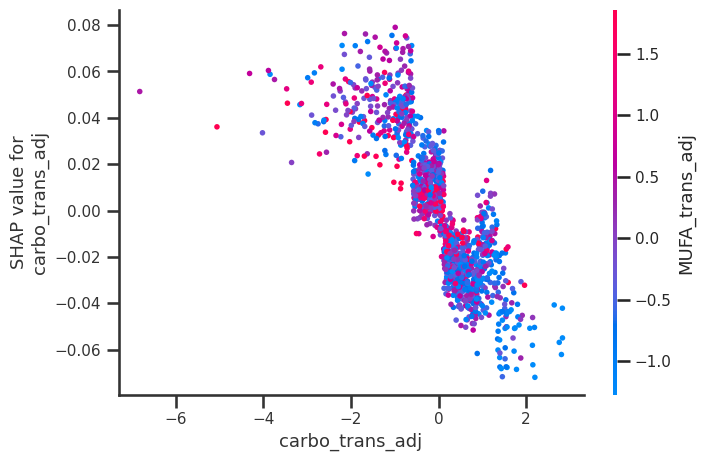

In [22]:
#最も重要度の高い特徴量と、次に高い特徴量の相互作用を見る
target_feature_1 = sorted_shap_importance_df['Feature'].iloc[0]
interaction_feature_2 = sorted_shap_importance_df['Feature'].iloc[1]

print(f"\n--- SHAP Dependence Plot with Interaction: {target_feature_1} vs {interaction_feature_2} ---")

shap.dependence_plot(
    target_feature_1,           # X軸: プロットしたい特徴量
    shap_values_class1,
    xDF_train,
    interaction_index=interaction_feature_2 # 色付けに使う特徴量
)

### ROC曲線の合併

In [19]:
filename = 'best_random_forest_None_c_model.joblib'
# joblib.load()を使用してモデルをメモリに読み込み、変数 'model' に格納
model1 = joblib.load(filename)

In [20]:
xDF_test1 = pd.read_csv('xDF_test.csv')
yDF_test1 = pd.read_csv('yDF_test.csv').iloc[:, 0]
print(f"xDF_test1 の型: {type(xDF_test1)}")
print(f"yDF_test1 の型: {type(yDF_test1)}")

xDF_test1 の型: <class 'pandas.core.frame.DataFrame'>
yDF_test1 の型: <class 'pandas.core.series.Series'>


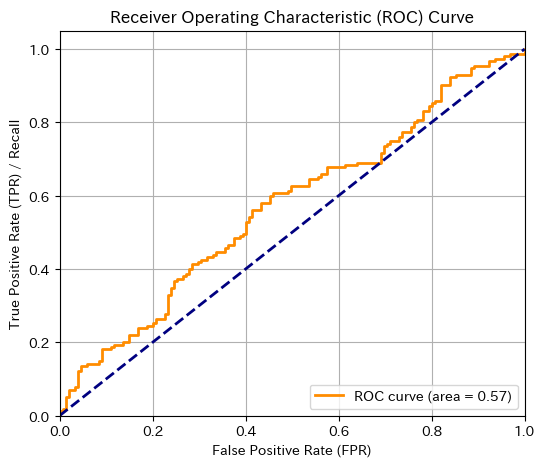


AUC (Area Under the Curve): 0.5713


In [21]:
# 1. 予測確率の取得
y_score = model1.predict_proba(xDF_test1)

# 2. 正解ラベルの準備 (二値化)
ptnA={'non_cancer':0,'oral_cancer':1}
yDF_test1=yDF_test1.map(ptnA)
y_true_binary = yDF_test1.values.ravel() 

# 3. ROC曲線の計算
fpr1, tpr1, thresholds = roc_curve(y_true_binary, y_score[:, 1])
roc_auc1 = auc(fpr1, tpr1)

# 4. ROC曲線のプロット
plt.figure(figsize=(6, 5))

# ROC曲線のプロット
plt.plot(
    fpr1, tpr1, color='darkorange', lw=2, 
    label=f'ROC curve (area = {roc_auc1:0.2f})'
)

# ランダムな分類器の対角線 (AUC=0.5)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# グラフの設定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)') # 偽陽性率
plt.ylabel('True Positive Rate (TPR) / Recall') # 真陽性率 / 再現率
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print(f'\nAUC (Area Under the Curve): {roc_auc1:.4f}')

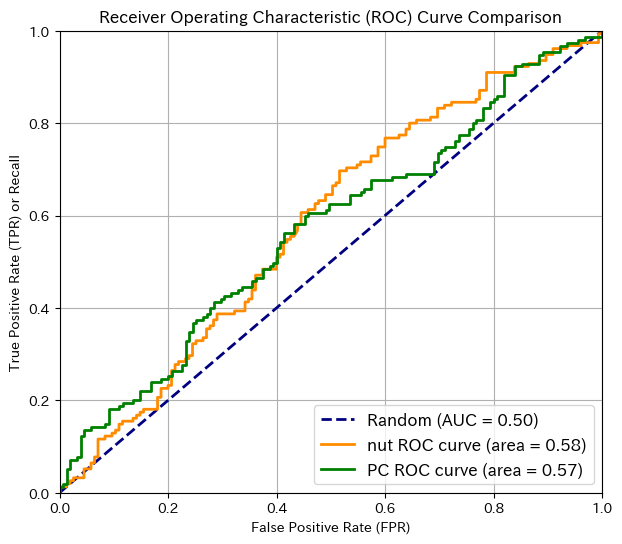

In [22]:
plt.figure(figsize=(7, 6)) # グラフの領域を一度だけ作成
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')

# ROC曲線のプロット (Model)
plt.plot(
    fpr, tpr, color='darkorange', lw=2,
    label=f'nut ROC curve (area = {roc_auc:.2f})'
)
# ROC曲線のプロット (Model1)
plt.plot( # 続けてプロットすることで、同じグラフに線が追加される
    fpr1, tpr1, color='green', lw=2, linestyle='-',
    label=f'PC ROC curve (area = {roc_auc1:.2f})'
)

plt.legend(loc="lower right", fontsize=12) 
# その他のグラフ設定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.grid(True)
plt.show()

In [23]:
plt.figure(figsize=(7, 6)) # グラフの領域を一度だけ作成
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random (AUC = 0.50)')

# ROC曲線のプロット (Model)
plt.plot(
    fpr, tpr, color='darkorange', lw=2,
    label=f'nut ROC curve (area = {roc_auc:.2f})'
)
# ROC曲線のプロット (Model1)
plt.plot(
    fpr1, tpr1, color='green', lw=2, linestyle='-',
    label=f'PC ROC curve (area = {roc_auc1:.2f})'
)

plt.legend(loc="lower right", fontsize=12) 

# その他のグラフ設定
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) or Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve Comparison')
plt.grid(True)

# プロットをファイルとして保存
plot_filename = 'roc_curve_comparison.png'
plt.savefig(plot_filename, bbox_inches='tight')

plt.close()

print(f"✅ ROC曲線比較プロットを '{plot_filename}' に保存しました。")

✅ ROC曲線比較プロットを 'roc_curve_comparison.png' に保存しました。
